In [1]:
# Block 1: imports, config, seed
import os, random
from pathlib import Path
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import transforms, datasets, models

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score

# -------- CONFIG --------
DATA_DIR = "Stripped"                     # root containing Training, Testing, Augmented
TRAIN_FOLDER = os.path.join(DATA_DIR, "Training")
TEST_FOLDER  = os.path.join(DATA_DIR, "Testing")
AUG_FOLDER   = os.path.join(DATA_DIR, "Augmented")

IMG_SIZE = 224
BATCH_SIZE = 64
NUM_WORKERS = 0
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

SEED = 42
LABELLED_FRACTION = 0.2   # 20% labelled
NUM_CLUSTERS = 4
EPOCHS = 20
LR = 1e-3
WEIGHT_DECAY = 1e-4
BACKBONE_PRETRAINED = True

# Pseudo-labeling configuration
PSEUDO_CONF_THRESHOLD = 0.7   # only use pseudo labels with confidence >= this
CLUSTER_METHOD = 'kmeans'        # 'kmeans' or 'gmm'
CLUSTER_COUNTS = [NUM_CLUSTERS]  # list of cluster counts to try/evaluate

# Hyperparameter sweep defaults (small grid)
LR_GRID = [1e-3, 5e-4]
ALPHA_GRID = [0.5, 1.0]

# reproducibility
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

print("Device:", DEVICE)

Device: cuda


In [2]:
    # Block 2: transforms + dataset + per-class labelled split (updated)
from torchvision.datasets import ImageFolder
# Custom ImageFolder that returns index along with (image, label) so we can map back to full-dataset indices
class ImageFolderWithIndex(ImageFolder):
    def __getitem__(self, index):
        # original returns (sample, target)
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return sample, target, index

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    # avoid vertical flips and large rotations for MRI unless explicitly validated
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

eval_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

# Use the new ImageFolderWithIndex so __getitem__ returns (img, label, idx)
train_dataset_aug = ImageFolderWithIndex(TRAIN_FOLDER, transform=train_transform)
train_dataset_eval = ImageFolderWithIndex(TRAIN_FOLDER, transform=eval_transform)
test_dataset = ImageFolderWithIndex(TEST_FOLDER, transform=eval_transform)

# per-class indices for splitting labelled/unlabelled (indices here refer to dataset indices)
class_to_indices = defaultdict(list)
for idx, (_, label) in enumerate(train_dataset_eval.samples):
    class_to_indices[label].append(idx)

labelled_idx = []
unlabelled_idx = []
for label, inds in class_to_indices.items():
    inds_sorted = list(inds)
    random.shuffle(inds_sorted)
    n_lab = max(1, int(len(inds_sorted) * LABELLED_FRACTION))
    labelled_idx += inds_sorted[:n_lab]
    unlabelled_idx += inds_sorted[n_lab:]

labelled_subset = Subset(train_dataset_aug, labelled_idx)
unlabelled_subset = Subset(train_dataset_aug, unlabelled_idx)
labelled_eval_subset = Subset(train_dataset_eval, labelled_idx)  # for feature extraction / eval

# loaders will now yield tuples: (img, label, idx) for subset datasets; handle accordingly in training loop
labelled_loader = DataLoader(labelled_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
unlabelled_loader = DataLoader(unlabelled_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
labelled_eval_loader = DataLoader(labelled_eval_subset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
train_eval_loader = DataLoader(train_dataset_eval, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print("Total train images:", len(train_dataset_eval))
print("Labelled:", len(labelled_subset), "Unlabelled:", len(unlabelled_subset))
print("Classes:", train_dataset_eval.classes)

Total train images: 5712
Labelled: 1141 Unlabelled: 4571
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [3]:
# Block 3: model definition
class DeepClusterModel(nn.Module):
    def __init__(self, backbone='resnet18', pretrained=True, feat_dim=512, num_clusters=NUM_CLUSTERS, num_classes=None):
        super().__init__()
        if backbone == 'resnet18':
            net = models.resnet18(pretrained=pretrained)
            in_feats = net.fc.in_features
            net.fc = nn.Identity()
            self.backbone = net
            feat_dim = in_feats
        else:
            raise NotImplementedError("Only resnet18 implemented in this block.")
        # projection head (small MLP)
        self.proj = nn.Sequential(
            nn.Linear(feat_dim, feat_dim//2),
            nn.ReLU(),
            nn.Linear(feat_dim//2, 256)
        )
        # cluster classification head (predict k-means cluster ids)
        self.cluster_head = nn.Linear(256, num_clusters)
        # supervised head for actual labels (if labelled)
        if num_classes is not None:
            self.sup_head = nn.Linear(256, num_classes)
        else:
            self.sup_head = None

    def forward(self, x):
        f = self.backbone(x)              # backbone features
        z = self.proj(f)                  # projection features
        z_norm = F.normalize(z, dim=1)    # normalize
        cluster_logits = self.cluster_head(z_norm)
        sup_logits = self.sup_head(z_norm) if self.sup_head is not None else None
        return z_norm, cluster_logits, sup_logits

# instantiate
num_classes = len(train_dataset_eval.classes)
model = DeepClusterModel(pretrained=BACKBONE_PRETRAINED, num_clusters=NUM_CLUSTERS, num_classes=num_classes).to(DEVICE)
print(model)


c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DeepClusterModel(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True,

In [8]:
# Block 4: utilities - feature extraction and clustering (updated)
@torch.no_grad()
def extract_features(loader, model, device=DEVICE, max_samples=None):
    model.eval()
    feats = []
    count = 0

    for batch in loader:
        # support (x,y) or (x,y,idx)
        if len(batch) == 2:
            x, y = batch
        elif len(batch) == 3:
            x, y, idx = batch
        else:
            raise ValueError('Unexpected batch format from loader')

        x = x.to(device)
        z, _, _ = model(x)
        feats.append(z.cpu().numpy())
        count += len(x)

        # stop early if max_samples reached
        if max_samples is not None and count >= max_samples:
            break

    feats = np.concatenate(feats, axis=0)
    if max_samples is not None:
        feats = feats[:max_samples]
    return feats  # shape (N, D)


def run_clustering(feats, n_clusters=NUM_CLUSTERS, method='kmeans', random_state=SEED):
    """Run clustering and return cluster ids and per-sample confidences.
    For kmeans: confidence = 1 - (distance_to_centroid / max_distance)
    For gmm: confidence = max posterior probability from GMM.predict_proba
    """
    if method == 'kmeans':
        km = KMeans(n_clusters=n_clusters, random_state=random_state, n_init=20)
        clusters = km.fit_predict(feats)
        # distances to assigned centroid
        centers = km.cluster_centers_
        dists = np.linalg.norm(feats - centers[clusters], axis=1)
        # normalize distances to [0,1] and invert to get confidence (higher = better)
        if len(dists)>0:
            maxd = dists.max()
            if maxd == 0:
                conf = np.ones_like(dists)
            else:
                conf = 1.0 - (dists / (maxd + 1e-8))
        else:
            conf = np.zeros_like(dists)
        return clusters, km, conf
    elif method == 'gmm':
        gmm = GaussianMixture(n_components=n_clusters, random_state=random_state, n_init=5)
        gmm.fit(feats)
        probs = gmm.predict_proba(feats)  # shape (N, n_components)
        clusters = probs.argmax(axis=1)
        conf = probs.max(axis=1)  # posterior probability as confidence
        return clusters, gmm, conf
    else:
        raise ValueError('Unknown clustering method')

# map cluster -> most frequent true label (for coarse eval)
def cluster_label_mapping(clusters, true_labels, n_clusters=NUM_CLUSTERS):
    mapping = {}
    for c in range(n_clusters):
        inds = np.where(clusters == c)[0]
        if len(inds)==0:
            mapping[c] = -1
            continue
        true = np.array(true_labels)[inds]
        # majority vote
        vals, counts = np.unique(true, return_counts=True)
        mapping[c] = int(vals[np.argmax(counts)])
    return mapping

In [9]:
# Block 5: optimizer, loss, train epoch (updated)
# set different lr for backbone vs heads (small LR for pretrained backbone)
backbone_params = list(model.backbone.parameters())
head_params = [p for name,p in model.named_parameters() if not name.startswith('backbone')]
optimizer = torch.optim.Adam([
    {'params': backbone_params, 'lr': LR * 0.1},
    {'params': model.proj.parameters(), 'lr': LR},
    {'params': model.cluster_head.parameters(), 'lr': LR},
    {'params': model.sup_head.parameters(), 'lr': LR} if model.sup_head is not None else {'params': []},
], weight_decay=WEIGHT_DECAY)

# remove empty param group if sup_head is None
optimizer.param_groups = [g for g in optimizer.param_groups if len(g['params'])>0]

# LR scheduler (cosine annealing)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

ce_loss = nn.CrossEntropyLoss()
ce_loss_none = nn.CrossEntropyLoss(reduction='none')  # per-sample losses for masking

def assign_pseudo_labels_to_unlabelled(model, eval_loader_for_all_train, method=CLUSTER_METHOD, n_clusters=NUM_CLUSTERS):
    # extract features for full training set (eval transforms)
    feats = extract_features(eval_loader_for_all_train, model, DEVICE)  # order same as dataset.samples
    clusters, cluster_model, confs = run_clustering(feats, n_clusters=n_clusters, method=method)
    return clusters, cluster_model, confs, feats

def train_one_epoch(model, labelled_loader, unlabelled_loader, pseudo_assignments_for_unlabelled, pseudo_confs_for_unlabelled, alpha=1.0, conf_threshold=PSEUDO_CONF_THRESHOLD):
    model.train()
    running_loss = 0.0
    total_samples = 0

    unlabel_iter = iter(unlabelled_loader)
    for batch_lab in labelled_loader:
        # unpack labelled batch (support (x,y,idx))
        if len(batch_lab) == 3:
            x_lab, y_lab, idx_lab = batch_lab
        else:
            x_lab, y_lab = batch_lab
            idx_lab = None

        try:
            batch_un = next(unlabel_iter)
        except StopIteration:
            unlabel_iter = iter(unlabelled_loader)
            batch_un = next(unlabel_iter)

        # unpack unlabelled batch
        if len(batch_un) == 3:
            x_unlab, y_unlab, idx_unlab = batch_un
        else:
            x_unlab, y_unlab = batch_un
            idx_unlab = None

        x_lab = x_lab.to(DEVICE); y_lab = y_lab.to(DEVICE)
        x_unlab = x_unlab.to(DEVICE)

        # supervised forward
        z_lab, _, sup_logits = model(x_lab)
        loss_sup = ce_loss(sup_logits, y_lab)

        # prepare pseudo targets and confidences for this unlabelled batch
        _, cluster_logits_un, _ = model(x_unlab)  # model outputs for pseudo loss
        if idx_unlab is None:
            # fallback: use model's own cluster logits as pseudo targets (low-confidence fallback)
            pseudo_targets = cluster_logits_un.detach().argmax(dim=1).to(DEVICE)
            pseudo_confs = torch.ones_like(pseudo_targets, dtype=torch.float, device=DEVICE) * 0.5
        else:
            # map batch dataset indices to global pseudo assignments and confidences
            if isinstance(idx_unlab, torch.Tensor):
                batch_indices = idx_unlab.cpu().numpy()
            else:
                batch_indices = np.array(idx_unlab)
            pseudo_targets_np = np.array(pseudo_assignments_for_unlabelled)[batch_indices]
            pseudo_confs_np = np.array(pseudo_confs_for_unlabelled)[batch_indices]
            pseudo_targets = torch.tensor(pseudo_targets_np, dtype=torch.long, device=DEVICE)
            pseudo_confs = torch.tensor(pseudo_confs_np, dtype=torch.float, device=DEVICE)

        # compute per-sample pseudo losses and mask by confidence
        losses_per_sample = ce_loss_none(cluster_logits_un, pseudo_targets)  # shape (B,)
        mask = (pseudo_confs >= conf_threshold)
        if mask.sum() > 0:
            loss_pseudo = losses_per_sample[mask].mean()
        else:
            loss_pseudo = torch.tensor(0.0, device=DEVICE)

        loss = loss_sup + alpha * loss_pseudo

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x_lab.size(0)
        total_samples += x_lab.size(0)

    avg_loss = running_loss / max(1, total_samples)
    return avg_loss

In [13]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os
import numpy as np
import torch

def tsne_epoch_plot(model, loader, clusters, epoch, title_prefix="Epoch", save_dir="tsne_plots2"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()

    feats, labels_true = [], []

    with torch.no_grad():
        for batch in loader:
            # handle variable batch formats
            x = batch[0].to(DEVICE)
            y = batch[1] if len(batch) >= 2 else None

            emb, _, _ = model(x)
            feats.append(emb.cpu().numpy())

            if y is not None:
                labels_true.append(y.numpy())

    # concatenate embeddings
    feats = np.concatenate(feats)
    if len(labels_true) > 0:
        labels_true = np.concatenate(labels_true)
    else:
        labels_true = np.zeros(len(feats))  # fallback dummy labels

    # --- optional PCA for speed ---
    pca_dim = min(50, feats.shape[1])
    pca = PCA(n_components=pca_dim)
    feats_reduced = pca.fit_transform(feats)

    # --- run t-SNE ---
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, init='pca', learning_rate='auto')
    feats_2d = tsne.fit_transform(feats_reduced)

    # --- ensure clusters length matches ---
    clusters = np.array(clusters)
    if len(clusters) < len(feats_2d):
        clusters = np.pad(clusters, (0, len(feats_2d) - len(clusters)), mode='wrap')

    # --- make side-by-side plot ---
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    for lab in np.unique(labels_true):
        idx = labels_true == lab
        plt.scatter(feats_2d[idx, 0], feats_2d[idx, 1], label=f"Class {int(lab)}", s=8)
    plt.title(f"{title_prefix} {epoch} – True Labels")
    plt.legend(fontsize=7)

    plt.subplot(1, 2, 2)
    for c in np.unique(clusters):
        idx = clusters == c
        plt.scatter(feats_2d[idx, 0], feats_2d[idx, 1], label=f"Cluster {int(c)}", s=8)
    plt.title(f"{title_prefix} {epoch} – Cluster Assignments")
    plt.legend(fontsize=7)

    plt.tight_layout()
    save_path = f"{save_dir}/tsne_epoch_{epoch}.png"
    plt.savefig(save_path, dpi=200)
    plt.close()
    print(f"🧩 Saved t-SNE plot for epoch {epoch} → {save_path}")


In [14]:
# Block 6: training orchestration (with t-SNE visualization) (updated)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import os

def save_confusion_matrix(y_true, y_pred, class_names, save_path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.close()

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Clusters", loc="best")
    plt.title(title)
    plt.show()

def evaluate_supervised(model, loader):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in loader:
            if len(batch) == 3:
                x, y, idx = batch
            else:
                x, y = batch
            x = x.to(DEVICE)
            _, _, sup_logits = model(x)
            preds.append(sup_logits.argmax(dim=1).cpu().numpy())
            trues.append(y.numpy())
    trues = np.concatenate(trues)
    preds = np.concatenate(preds)
    acc = accuracy_score(trues, preds)
    # per-class report
    report = classification_report(trues, preds, output_dict=True, zero_division=0)
    return acc, report, trues, preds

alpha = 1.0
best_acc = 0.0

for epoch in range(1, EPOCHS + 1):
    print(f"\n=== Epoch {epoch} ===")

    # 1️⃣ Extract features for full training set (using eval transforms)
    print("Starting feature extraction...")
    feats = extract_features(train_eval_loader, model, DEVICE, max_samples=3000)
    print(f"Feature extraction done! Extracted {len(feats)} samples.")

    # 2️⃣ Run clustering
    print("Running clustering...")
    clusters, cluster_model, confs = run_clustering(
        feats, n_clusters=CLUSTER_COUNTS[0], method=CLUSTER_METHOD
    )
    print("Clustering done!")

    # If we used fewer samples, ensure lengths align with dataset
    max_samples_used = len(feats)
    clusters = np.array(clusters)
    confs = np.array(confs)

    # Pad clusters/confs if dataset is bigger — this avoids IndexError
    full_dataset_size = len(train_eval_loader.dataset)
    if max_samples_used < full_dataset_size:
        pad_size = full_dataset_size - max_samples_used
        print(f"⚠️ Only extracted {max_samples_used}/{full_dataset_size} samples — padding the rest with dummy cluster/conf values.")
        clusters = np.concatenate([clusters, np.full(pad_size, clusters.mean(), dtype=int)])
        confs = np.concatenate([confs, np.full(pad_size, confs.mean())])

    print("Training starts...")

    # 3️⃣ Compute mapping between clusters and true labels (for monitoring)
    true_labels_all = []
    for batch in train_eval_loader:
        if len(batch) == 3:
            _, y_batch, _ = batch
        else:
            _, y_batch = batch
        true_labels_all.append(y_batch.numpy())
    true_labels_all = np.concatenate(true_labels_all)
    mapping = cluster_label_mapping(clusters, true_labels_all, n_clusters=CLUSTER_COUNTS[0])
    print(f"Epoch {epoch}: cluster->label mapping: {mapping}")

    # 4️⃣ Train for one epoch using pseudo-labels (clusters aligned to dataset indices)
    loss = train_one_epoch(model, labelled_loader, unlabelled_loader, clusters, confs, alpha=alpha)
    print(f"Epoch {epoch} train loss: {loss:.4f}")

    # LR scheduler step
    try:
        scheduler.step()
    except Exception:
        pass

    # 5️⃣ Evaluate supervised branch on test data
    acc, report, trues, preds = evaluate_supervised(model, test_loader)
    print(f"Epoch {epoch} test acc: {acc:.4f}")
    for cls_idx, cls_name in enumerate(test_dataset.classes):
        cls_metrics = report.get(str(cls_idx), {'precision':0,'recall':0,'f1-score':0})
        print(f"Class {cls_idx} ({cls_name}): precision={cls_metrics['precision']:.3f}, recall={cls_metrics['recall']:.3f}, f1={cls_metrics['f1-score']:.3f}")

    os.makedirs('confusion_matrices', exist_ok=True)
    save_confusion_matrix(trues, preds, test_dataset.classes, f'confusion_matrices/confusion_epoch_{epoch}.png')
    print(f'Confusion matrix saved → confusion_matrices/confusion_epoch_{epoch}.png')

    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), "best_deepcluster_model.pth")
        print("✅ Saved best model.")

    # 6️⃣ Epoch-wise t-SNE visualization (optional)
    if epoch in [1, 5, 10, 15, 20]:
        tsne_epoch_plot(model, train_eval_loader, clusters, epoch)

print('Training finished. Best acc:', best_acc)



=== Epoch 1 ===
Starting feature extraction...
Feature extraction done! Extracted 3000 samples.
Running clustering...
Feature extraction done! Extracted 3000 samples.
Running clustering...


c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 1: cluster->label mapping: {0: 1, 1: 3, 2: 2, 3: 1}
Epoch 1: cluster->label mapping: {0: 1, 1: 3, 2: 2, 3: 1}
Epoch 1 train loss: 2.0795
Epoch 1 train loss: 2.0795
Epoch 1 test acc: 0.8146
Class 0 (glioma): precision=0.844, recall=0.903, f1=0.873
Class 1 (meningioma): precision=0.654, recall=0.644, f1=0.649
Class 2 (notumor): precision=0.827, recall=0.956, f1=0.887
Class 3 (pituitary): precision=0.964, recall=0.710, f1=0.818
Confusion matrix saved → confusion_matrices/confusion_epoch_1.png
Epoch 1 test acc: 0.8146
Class 0 (glioma): precision=0.844, recall=0.903, f1=0.873
Class 1 (meningioma): precision=0.654, recall=0.644, f1=0.649
Class 2 (notumor): precision=0.827, recall=0.956, f1=0.887
Class 3 (pituitary): precision=0.964, recall=0.710, f1=0.818
Confusion matrix saved → confusion_matrices/confusion_epoch_1.png
✅ Saved best model.
✅ Saved best model.
🧩 Sav

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 2: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 2: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 2 train loss: 2.1562
Epoch 2 train loss: 2.1562
Epoch 2 test acc: 0.8703
Class 0 (glioma): precision=0.946, recall=0.823, f1=0.881
Class 1 (meningioma): precision=0.781, recall=0.690, f1=0.733
Class 2 (notumor): precision=0.877, recall=0.953, f1=0.914
Class 3 (pituitary): precision=0.874, recall=0.990, f1=0.928
Confusion matrix saved → confusion_matrices/confusion_epoch_2.png
Epoch 2 test acc: 0.8703
Class 0 (glioma): precision=0.946, recall=0.823, f1=0.881
Class 1 (meningioma): precision=0.781, recall=0.690, f1=0.733
Class 2 (notumor): precision=0.877, recall=0.953, f1=0.914
Class 3 (pituitary): precision=0.874, recall=0.990, f1=0.928
Confusion matrix saved → confusion_matrices/confusion_epoch_2.png
✅ Saved best model.

=== Epoch 3 ===
Starting

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 3: cluster->label mapping: {0: 0, 1: 2, 2: 1, 3: 1}
Epoch 3: cluster->label mapping: {0: 0, 1: 2, 2: 1, 3: 1}
Epoch 3 train loss: 1.7873
Epoch 3 train loss: 1.7873
Epoch 3 test acc: 0.8612
Class 0 (glioma): precision=0.917, recall=0.927, f1=0.922
Class 1 (meningioma): precision=0.682, recall=0.814, f1=0.742
Class 2 (notumor): precision=0.919, recall=0.975, f1=0.946
Class 3 (pituitary): precision=0.972, recall=0.690, f1=0.807
Confusion matrix saved → confusion_matrices/confusion_epoch_3.png

=== Epoch 4 ===
Starting feature extraction...
Epoch 3 test acc: 0.8612
Class 0 (glioma): precision=0.917, recall=0.927, f1=0.922
Class 1 (meningioma): precision=0.682, recall=0.814, f1=0.742
Class 2 (notumor): precision=0.919, recall=0.975, f1=0.946
Class 3 (pituitary): precision=0.972, recall=0.690, f1=0.807
Confusion matrix saved → confusion_matrices/confusion_epoch_3.p

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 4: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 4: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 4 train loss: 1.8485
Epoch 4 train loss: 1.8485
Epoch 4 test acc: 0.8863
Class 0 (glioma): precision=0.895, recall=0.907, f1=0.901
Class 1 (meningioma): precision=0.764, recall=0.869, f1=0.813
Class 2 (notumor): precision=0.925, recall=0.973, f1=0.948
Class 3 (pituitary): precision=0.987, recall=0.767, f1=0.863
Epoch 4 test acc: 0.8863
Class 0 (glioma): precision=0.895, recall=0.907, f1=0.901
Class 1 (meningioma): precision=0.764, recall=0.869, f1=0.813
Class 2 (notumor): precision=0.925, recall=0.973, f1=0.948
Class 3 (pituitary): precision=0.987, recall=0.767, f1=0.863
Confusion matrix saved → confusion_matrices/confusion_epoch_4.png
✅ Saved best model.

=== Epoch 5 ===
Starting feature extraction...
Confusion matrix saved → confusion_matrices

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 5: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 5: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 5 train loss: 1.4805
Epoch 5 train loss: 1.4805
Epoch 5 test acc: 0.9336
Class 0 (glioma): precision=0.952, recall=0.920, f1=0.936
Class 1 (meningioma): precision=0.889, recall=0.859, f1=0.874
Class 2 (notumor): precision=0.936, recall=0.968, f1=0.951
Class 3 (pituitary): precision=0.958, recall=0.977, f1=0.967
Confusion matrix saved → confusion_matrices/confusion_epoch_5.png
Epoch 5 test acc: 0.9336
Class 0 (glioma): precision=0.952, recall=0.920, f1=0.936
Class 1 (meningioma): precision=0.889, recall=0.859, f1=0.874
Class 2 (notumor): precision=0.936, recall=0.968, f1=0.951
Class 3 (pituitary): precision=0.958, recall=0.977, f1=0.967
Confusion matrix saved → confusion_matrices/confusion_epoch_5.png
✅ Saved best model.
✅ Saved best model.
🧩 Sav

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 6: cluster->label mapping: {0: 2, 1: 3, 2: 0, 3: 1}
Epoch 6: cluster->label mapping: {0: 2, 1: 3, 2: 0, 3: 1}
Epoch 6 train loss: 1.5173
Epoch 6 train loss: 1.5173
Epoch 6 test acc: 0.8719
Class 0 (glioma): precision=0.973, recall=0.847, f1=0.906
Class 1 (meningioma): precision=0.687, recall=0.859, f1=0.763
Class 2 (notumor): precision=0.927, recall=0.968, f1=0.947
Class 3 (pituitary): precision=0.959, recall=0.780, f1=0.860
Confusion matrix saved → confusion_matrices/confusion_epoch_6.png

=== Epoch 7 ===
Starting feature extraction...
Epoch 6 test acc: 0.8719
Class 0 (glioma): precision=0.973, recall=0.847, f1=0.906
Class 1 (meningioma): precision=0.687, recall=0.859, f1=0.763
Class 2 (notumor): precision=0.927, recall=0.968, f1=0.947
Class 3 (pituitary): precision=0.959, recall=0.780, f1=0.860
Confusion matrix saved → confusion_matrices/confusion_epoch_6.p

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 7: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 0}
Epoch 7: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 0}
Epoch 7 train loss: 1.7436
Epoch 7 train loss: 1.7436
Epoch 7 test acc: 0.9306
Class 0 (glioma): precision=0.909, recall=0.937, f1=0.923
Class 1 (meningioma): precision=0.907, recall=0.827, f1=0.865
Class 2 (notumor): precision=0.942, recall=0.970, f1=0.956
Class 3 (pituitary): precision=0.958, recall=0.977, f1=0.967
Confusion matrix saved → confusion_matrices/confusion_epoch_7.png

=== Epoch 8 ===
Starting feature extraction...
Epoch 7 test acc: 0.9306
Class 0 (glioma): precision=0.909, recall=0.937, f1=0.923
Class 1 (meningioma): precision=0.907, recall=0.827, f1=0.865
Class 2 (notumor): precision=0.942, recall=0.970, f1=0.956
Class 3 (pituitary): precision=0.958, recall=0.977, f1=0.967
Confusion matrix saved → confusion_matrices/confusion_epoch_7.p

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 8: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 1}
Epoch 8: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 1}
Epoch 8 train loss: 1.3156
Epoch 8 train loss: 1.3156
Epoch 8 test acc: 0.9138
Class 0 (glioma): precision=0.923, recall=0.920, f1=0.922
Class 1 (meningioma): precision=0.839, recall=0.837, f1=0.838
Class 2 (notumor): precision=0.927, recall=0.968, f1=0.947
Class 3 (pituitary): precision=0.965, recall=0.913, f1=0.938
Confusion matrix saved → confusion_matrices/confusion_epoch_8.png

=== Epoch 9 ===
Starting feature extraction...
Epoch 8 test acc: 0.9138
Class 0 (glioma): precision=0.923, recall=0.920, f1=0.922
Class 1 (meningioma): precision=0.839, recall=0.837, f1=0.838
Class 2 (notumor): precision=0.927, recall=0.968, f1=0.947
Class 3 (pituitary): precision=0.965, recall=0.913, f1=0.938
Confusion matrix saved → confusion_matrices/confusion_epoch_8.p

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 9: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 9: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 9 train loss: 1.2140
Epoch 9 train loss: 1.2140
Epoch 9 test acc: 0.9314
Class 0 (glioma): precision=0.957, recall=0.900, f1=0.928
Class 1 (meningioma): precision=0.839, recall=0.905, f1=0.871
Class 2 (notumor): precision=0.963, recall=0.956, f1=0.959
Class 3 (pituitary): precision=0.966, recall=0.957, f1=0.961
Confusion matrix saved → confusion_matrices/confusion_epoch_9.png

=== Epoch 10 ===
Starting feature extraction...
Epoch 9 test acc: 0.9314
Class 0 (glioma): precision=0.957, recall=0.900, f1=0.928
Class 1 (meningioma): precision=0.839, recall=0.905, f1=0.871
Class 2 (notumor): precision=0.963, recall=0.956, f1=0.959
Class 3 (pituitary): precision=0.966, recall=0.957, f1=0.961
Confusion matrix saved → confusion_matrices/confusion_epoch_9.

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 10: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 1}
Epoch 10: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 1}
Epoch 10 train loss: 1.1709
Epoch 10 train loss: 1.1709
Epoch 10 test acc: 0.9352
Class 0 (glioma): precision=0.934, recall=0.950, f1=0.942
Class 1 (meningioma): precision=0.914, recall=0.830, f1=0.870
Class 2 (notumor): precision=0.933, recall=0.965, f1=0.949
Class 3 (pituitary): precision=0.958, recall=0.987, f1=0.972
Confusion matrix saved → confusion_matrices/confusion_epoch_10.png
Epoch 10 test acc: 0.9352
Class 0 (glioma): precision=0.934, recall=0.950, f1=0.942
Class 1 (meningioma): precision=0.914, recall=0.830, f1=0.870
Class 2 (notumor): precision=0.933, recall=0.965, f1=0.949
Class 3 (pituitary): precision=0.958, recall=0.987, f1=0.972
Confusion matrix saved → confusion_matrices/confusion_epoch_10.png
✅ Saved best model.
✅ Saved best mode

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 11: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 1}
Epoch 11: cluster->label mapping: {0: 3, 1: 0, 2: 2, 3: 1}
Epoch 11 train loss: 1.0624
Epoch 11 train loss: 1.0624
Epoch 11 test acc: 0.9252
Class 0 (glioma): precision=0.957, recall=0.890, f1=0.922
Class 1 (meningioma): precision=0.844, recall=0.869, f1=0.857
Class 2 (notumor): precision=0.942, recall=0.965, f1=0.954
Class 3 (pituitary): precision=0.957, recall=0.963, f1=0.960
Confusion matrix saved → confusion_matrices/confusion_epoch_11.png

=== Epoch 12 ===
Starting feature extraction...
Epoch 11 test acc: 0.9252
Class 0 (glioma): precision=0.957, recall=0.890, f1=0.922
Class 1 (meningioma): precision=0.844, recall=0.869, f1=0.857
Class 2 (notumor): precision=0.942, recall=0.965, f1=0.954
Class 3 (pituitary): precision=0.957, recall=0.963, f1=0.960
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 12: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 12: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 12 train loss: 1.1012
Epoch 12 train loss: 1.1012
Epoch 12 test acc: 0.9176
Class 0 (glioma): precision=0.963, recall=0.863, f1=0.910
Class 1 (meningioma): precision=0.801, recall=0.882, f1=0.840
Class 2 (notumor): precision=0.945, recall=0.968, f1=0.956
Class 3 (pituitary): precision=0.972, recall=0.940, f1=0.956
Confusion matrix saved → confusion_matrices/confusion_epoch_12.png

=== Epoch 13 ===
Starting feature extraction...
Epoch 12 test acc: 0.9176
Class 0 (glioma): precision=0.963, recall=0.863, f1=0.910
Class 1 (meningioma): precision=0.801, recall=0.882, f1=0.840
Class 2 (notumor): precision=0.945, recall=0.968, f1=0.956
Class 3 (pituitary): precision=0.972, recall=0.940, f1=0.956
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 13: cluster->label mapping: {0: 0, 1: 3, 2: 1, 3: 2}
Epoch 13: cluster->label mapping: {0: 0, 1: 3, 2: 1, 3: 2}
Epoch 13 train loss: 1.7792
Epoch 13 train loss: 1.7792
Epoch 13 test acc: 0.9230
Class 0 (glioma): precision=0.971, recall=0.883, f1=0.925
Class 1 (meningioma): precision=0.803, recall=0.908, f1=0.853
Class 2 (notumor): precision=0.954, recall=0.968, f1=0.961
Class 3 (pituitary): precision=0.979, recall=0.917, f1=0.947
Confusion matrix saved → confusion_matrices/confusion_epoch_13.png

=== Epoch 14 ===
Starting feature extraction...
Epoch 13 test acc: 0.9230
Class 0 (glioma): precision=0.971, recall=0.883, f1=0.925
Class 1 (meningioma): precision=0.803, recall=0.908, f1=0.853
Class 2 (notumor): precision=0.954, recall=0.968, f1=0.961
Class 3 (pituitary): precision=0.979, recall=0.917, f1=0.947
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 14: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 14: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 14 train loss: 1.0029
Epoch 14 train loss: 1.0029
Epoch 14 test acc: 0.9329
Class 0 (glioma): precision=0.974, recall=0.890, f1=0.930
Class 1 (meningioma): precision=0.827, recall=0.922, f1=0.872
Class 2 (notumor): precision=0.960, recall=0.960, f1=0.960
Class 3 (pituitary): precision=0.979, recall=0.950, f1=0.964
Confusion matrix saved → confusion_matrices/confusion_epoch_14.png

=== Epoch 15 ===
Starting feature extraction...
Epoch 14 test acc: 0.9329
Class 0 (glioma): precision=0.974, recall=0.890, f1=0.930
Class 1 (meningioma): precision=0.827, recall=0.922, f1=0.872
Class 2 (notumor): precision=0.960, recall=0.960, f1=0.960
Class 3 (pituitary): precision=0.979, recall=0.950, f1=0.964
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 15: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 15: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 15 train loss: 0.9463
Epoch 15 train loss: 0.9463
Epoch 15 test acc: 0.9321
Class 0 (glioma): precision=0.974, recall=0.883, f1=0.927
Class 1 (meningioma): precision=0.832, recall=0.908, f1=0.869
Class 2 (notumor): precision=0.954, recall=0.973, f1=0.963
Class 3 (pituitary): precision=0.976, recall=0.950, f1=0.963
Confusion matrix saved → confusion_matrices/confusion_epoch_15.png
Epoch 15 test acc: 0.9321
Class 0 (glioma): precision=0.974, recall=0.883, f1=0.927
Class 1 (meningioma): precision=0.832, recall=0.908, f1=0.869
Class 2 (notumor): precision=0.954, recall=0.973, f1=0.963
Class 3 (pituitary): precision=0.976, recall=0.950, f1=0.963
Confusion matrix saved → confusion_matrices/confusion_epoch_15.png
🧩 Saved t-SNE plot for epoch 15 → tsn

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 16: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 16: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 16 train loss: 0.9236
Epoch 16 train loss: 0.9236
Epoch 16 test acc: 0.9314
Class 0 (glioma): precision=0.974, recall=0.880, f1=0.925
Class 1 (meningioma): precision=0.835, recall=0.912, f1=0.872
Class 2 (notumor): precision=0.958, recall=0.963, f1=0.961
Class 3 (pituitary): precision=0.963, recall=0.960, f1=0.962
Confusion matrix saved → confusion_matrices/confusion_epoch_16.png

=== Epoch 17 ===
Starting feature extraction...
Epoch 16 test acc: 0.9314
Class 0 (glioma): precision=0.974, recall=0.880, f1=0.925
Class 1 (meningioma): precision=0.835, recall=0.912, f1=0.872
Class 2 (notumor): precision=0.958, recall=0.963, f1=0.961
Class 3 (pituitary): precision=0.963, recall=0.960, f1=0.962
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 17: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 17: cluster->label mapping: {0: 3, 1: 1, 2: 2, 3: 1}
Epoch 17 train loss: 0.8894
Epoch 17 train loss: 0.8894
Epoch 17 test acc: 0.9321
Class 0 (glioma): precision=0.971, recall=0.890, f1=0.929
Class 1 (meningioma): precision=0.840, recall=0.908, f1=0.873
Class 2 (notumor): precision=0.956, recall=0.965, f1=0.961
Class 3 (pituitary): precision=0.966, recall=0.953, f1=0.960
Confusion matrix saved → confusion_matrices/confusion_epoch_17.png

=== Epoch 18 ===
Starting feature extraction...
Epoch 17 test acc: 0.9321
Class 0 (glioma): precision=0.971, recall=0.890, f1=0.929
Class 1 (meningioma): precision=0.840, recall=0.908, f1=0.873
Class 2 (notumor): precision=0.956, recall=0.965, f1=0.961
Class 3 (pituitary): precision=0.966, recall=0.953, f1=0.960
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 18: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 18: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 18 train loss: 0.9034
Epoch 18 train loss: 0.9034
Epoch 18 test acc: 0.9291
Class 0 (glioma): precision=0.974, recall=0.877, f1=0.923
Class 1 (meningioma): precision=0.832, recall=0.905, f1=0.867
Class 2 (notumor): precision=0.956, recall=0.965, f1=0.961
Class 3 (pituitary): precision=0.960, recall=0.957, f1=0.958
Confusion matrix saved → confusion_matrices/confusion_epoch_18.png

=== Epoch 19 ===
Starting feature extraction...
Epoch 18 test acc: 0.9291
Class 0 (glioma): precision=0.974, recall=0.877, f1=0.923
Class 1 (meningioma): precision=0.832, recall=0.905, f1=0.867
Class 2 (notumor): precision=0.956, recall=0.965, f1=0.961
Class 3 (pituitary): precision=0.960, recall=0.957, f1=0.958
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 19: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 19: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 19 train loss: 0.8891
Epoch 19 train loss: 0.8891
Epoch 19 test acc: 0.9298
Class 0 (glioma): precision=0.974, recall=0.873, f1=0.921
Class 1 (meningioma): precision=0.830, recall=0.908, f1=0.867
Class 2 (notumor): precision=0.956, recall=0.968, f1=0.962
Class 3 (pituitary): precision=0.966, recall=0.957, f1=0.961
Confusion matrix saved → confusion_matrices/confusion_epoch_19.png

=== Epoch 20 ===
Starting feature extraction...
Epoch 19 test acc: 0.9298
Class 0 (glioma): precision=0.974, recall=0.873, f1=0.921
Class 1 (meningioma): precision=0.830, recall=0.908, f1=0.867
Class 2 (notumor): precision=0.956, recall=0.968, f1=0.962
Class 3 (pituitary): precision=0.966, recall=0.957, f1=0.961
Confusion matrix saved → confusion_matrices/confusion_e

c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


Clustering done!
⚠️ Only extracted 3000/5712 samples — padding the rest with dummy cluster/conf values.
Training starts...
Epoch 20: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 20: cluster->label mapping: {0: 3, 1: 1, 2: 1, 3: 2}
Epoch 20 train loss: 0.9338
Epoch 20 train loss: 0.9338
Epoch 20 test acc: 0.9314
Class 0 (glioma): precision=0.971, recall=0.890, f1=0.929
Class 1 (meningioma): precision=0.840, recall=0.892, f1=0.865
Class 2 (notumor): precision=0.947, recall=0.973, f1=0.960
Class 3 (pituitary): precision=0.973, recall=0.957, f1=0.965
Confusion matrix saved → confusion_matrices/confusion_epoch_20.png
Epoch 20 test acc: 0.9314
Class 0 (glioma): precision=0.971, recall=0.890, f1=0.929
Class 1 (meningioma): precision=0.840, recall=0.892, f1=0.865
Class 2 (notumor): precision=0.947, recall=0.973, f1=0.960
Class 3 (pituitary): precision=0.973, recall=0.957, f1=0.965
Confusion matrix saved → confusion_matrices/confusion_epoch_20.png
🧩 Saved t-SNE plot for epoch 20 → tsn

C:\Users\HP\AppData\Local\Temp\ipykernel_33400\1641170649.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_deepcluster_model.pth")

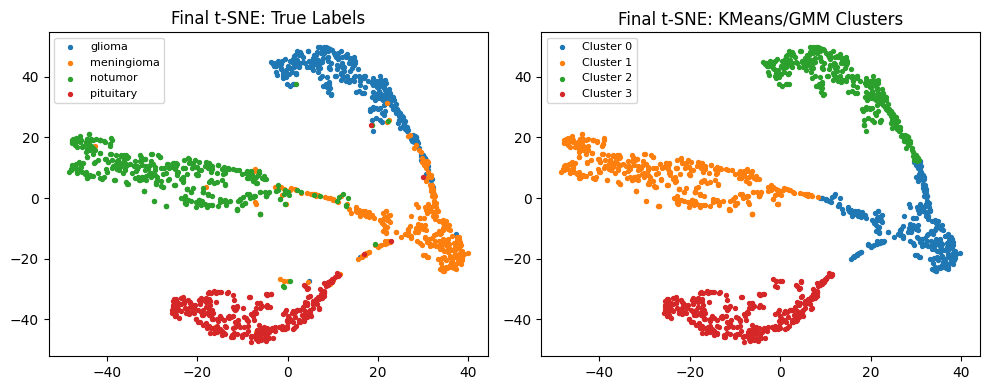

Saved final confusion matrix → confusion_matrices/confusion_final.png


In [15]:
# Block 7: Final visualization with t-SNE (after training) (updated)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import os

def plot_tsne_final(embeddings, labels_true, clusters_pred, class_names, title_prefix="Final"):
    """Plot t-SNE comparison of true labels vs cluster assignments."""
    # Optional: speed up t-SNE using PCA-reduced features
    pca = PCA(n_components=min(50, embeddings.shape[1]))  # reduce to 50 dims for speed
    reduced_feats = pca.fit_transform(embeddings)

    tsne = TSNE(n_components=2, random_state=SEED, perplexity=30, init='pca')
    feats_2d = tsne.fit_transform(reduced_feats)

    plt.figure(figsize=(10, 4))

    # Left: colored by true labels
    plt.subplot(1, 2, 1)
    for lab in np.unique(labels_true):
        inds = labels_true == lab
        plt.scatter(feats_2d[inds, 0], feats_2d[inds, 1], label=class_names[lab], s=8)
    plt.title(f"{title_prefix}: True Labels")
    plt.legend(fontsize=8)

    # Right: colored by clusters
    plt.subplot(1, 2, 2)
    for c in np.unique(clusters_pred):
        inds = clusters_pred == c
        plt.scatter(feats_2d[inds, 0], feats_2d[inds, 1], label=f"Cluster {c}", s=8)
    plt.title(f"{title_prefix}: KMeans/GMM Clusters")
    plt.legend(fontsize=8)

    plt.tight_layout()
    plt.show()

# --- Extract test features using best model ---
model.load_state_dict(torch.load("best_deepcluster_model.pth"))
model.eval()

feats_test = extract_features(test_loader, model, DEVICE)  # shape (N, D)
clusters_test, cluster_model_test, confs_test = run_clustering(feats_test, n_clusters=CLUSTER_COUNTS[0], method=CLUSTER_METHOD)

# Collect true test labels
y_test = []
for batch in test_loader:
    if len(batch) == 3:
        _, y_batch, _ = batch
    else:
        _, y_batch = batch
    y_test.append(y_batch.numpy())
y_test = np.concatenate(y_test)

# Visualize final embeddings
plot_tsne_final(feats_test, y_test, clusters_test, test_dataset.classes, title_prefix="Final t-SNE")

# Save final confusion matrix
os.makedirs('confusion_matrices', exist_ok=True)
save_confusion_matrix(y_test, clusters_test, test_dataset.classes, 'confusion_matrices/confusion_final.png')
print('Saved final confusion matrix → confusion_matrices/confusion_final.png')

In [16]:
# Hyperparameter sweep (small grid). Run this cell to execute short experiments (few epochs) and record results.
import copy
import pandas as pd
import time

def run_experiment(LR_val, alpha_val, epochs=3):
    # create a fresh model instance with same architecture
    model_exp = DeepClusterModel(pretrained=BACKBONE_PRETRAINED, num_clusters=CLUSTER_COUNTS[0], num_classes=num_classes).to(DEVICE)
    # optimizer similar to main training (small backbone lr)
    backbone_params = list(model_exp.backbone.parameters())
    optimizer_exp = torch.optim.Adam([
        {'params': backbone_params, 'lr': LR_val * 0.1},
        {'params': model_exp.proj.parameters(), 'lr': LR_val},
        {'params': model_exp.cluster_head.parameters(), 'lr': LR_val},
        {'params': model_exp.sup_head.parameters(), 'lr': LR_val} if model_exp.sup_head is not None else {'params': []},
    ], weight_decay=WEIGHT_DECAY)
    optimizer_exp.param_groups = [g for g in optimizer_exp.param_groups if len(g['params'])>0]
    scheduler_exp = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_exp, T_max=epochs)
    ce_loss_local = nn.CrossEntropyLoss()
    ce_loss_none_local = nn.CrossEntropyLoss(reduction='none')

    best_acc_local = 0.0
    start_time = time.time()
    for epoch in range(1, epochs+1):
        # clustering assignment using current model (eval transforms)
        feats_all = extract_features(train_eval_loader, model_exp, DEVICE)
        clusters_all, cluster_model_all, confs_all = run_clustering(feats_all, n_clusters=CLUSTER_COUNTS[0], method=CLUSTER_METHOD)

        # training loop (simplified supervised + pseudo with confidence)
        model_exp.train()
        unlabel_iter = iter(unlabelled_loader)
        for batch_lab in labelled_loader:
            if len(batch_lab)==3:
                x_lab, y_lab, _ = batch_lab
            else:
                x_lab, y_lab = batch_lab
            try:
                batch_un = next(unlabel_iter)
            except StopIteration:
                unlabel_iter = iter(unlabelled_loader)
                batch_un = next(unlabel_iter)
            if len(batch_un)==3:
                x_un, _, idx_un = batch_un
            else:
                x_un, _ = batch_un
                idx_un = None
            x_lab = x_lab.to(DEVICE); y_lab = y_lab.to(DEVICE)
            x_un = x_un.to(DEVICE)

            _, cluster_logits_un, _ = model_exp(x_un)
            # map pseudo labels by indices if available
            if idx_un is not None:
                if isinstance(idx_un, torch.Tensor):
                    batch_indices = idx_un.cpu().numpy()
                else:
                    batch_indices = np.array(idx_un)
                pseudo_targets_np = np.array(clusters_all)[batch_indices]
                pseudo_confs_np = np.array(confs_all)[batch_indices]
                pseudo_targets = torch.tensor(pseudo_targets_np, dtype=torch.long, device=DEVICE)
                pseudo_confs = torch.tensor(pseudo_confs_np, dtype=torch.float, device=DEVICE)
            else:
                pseudo_targets = cluster_logits_un.detach().argmax(dim=1).to(DEVICE)
                pseudo_confs = torch.ones_like(pseudo_targets, dtype=torch.float, device=DEVICE)*0.5

            _, _, sup_logits = model_exp(x_lab)
            loss_sup = ce_loss_local(sup_logits, y_lab)

            losses_per_sample = ce_loss_none_local(cluster_logits_un, pseudo_targets)
            mask = (pseudo_confs >= PSEUDO_CONF_THRESHOLD)
            if mask.sum()>0:
                loss_pseudo = losses_per_sample[mask].mean()
            else:
                loss_pseudo = torch.tensor(0.0, device=DEVICE)

            loss = loss_sup + alpha_val * loss_pseudo

            optimizer_exp.zero_grad()
            loss.backward()
            optimizer_exp.step()

        try:
            scheduler_exp.step()
        except Exception:
            pass

        # evaluate on test
        acc_local, _, _, _ = evaluate_supervised(model_exp, test_loader)
        if acc_local > best_acc_local:
            best_acc_local = acc_local

    elapsed = time.time() - start_time
    return best_acc_local, elapsed

# run sweep and record results (this may take time)
results = []
for lr_val in LR_GRID:
    for alpha_val in ALPHA_GRID:
        print(f"Running sweep: LR={lr_val}, alpha={alpha_val}")
        acc_r, took = run_experiment(lr_val, alpha_val, epochs=3)
        results.append({'lr': lr_val, 'alpha': alpha_val, 'best_test_acc': acc_r, 'time_s': took})
        print(f"Done: LR={lr_val}, alpha={alpha_val} -> best_acc={acc_r} (took {took:.1f}s)")

df_results = pd.DataFrame(results)
df_results.to_csv('hp_sweep_results.csv', index=False)
print('Saved hyperparameter sweep results → hp_sweep_results.csv')

Running sweep: LR=0.001, alpha=0.5


c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done: LR=0.001, alpha=0.5 -> best_acc=0.8535469107551488 (took 298.3s)
Running sweep: LR=0.001, alpha=1.0


c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done: LR=0.001, alpha=1.0 -> best_acc=0.8436308161708619 (took 297.6s)
Running sweep: LR=0.0005, alpha=0.5


c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done: LR=0.0005, alpha=0.5 -> best_acc=0.8352402745995423 (took 348.4s)
Running sweep: LR=0.0005, alpha=1.0


c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\HP\anaconda3\envs\btpenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done: LR=0.0005, alpha=1.0 -> best_acc=0.813119755911518 (took 369.3s)
Saved hyperparameter sweep results → hp_sweep_results.csv


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Device:", torch.device("cuda" if torch.cuda.is_available() else "cpu"))


CUDA available: True
Device: cuda
